In [1]:
def generate_solution(nx, ny, Lx, Ly, cx, cy, s):
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    dt = DT
    tend = TEND
    t = 0

    cfl_x, cfl_y = cx * dt/dx, cy * dt/dy
    diff_x, diff_y = s * dt/dx**2, s * dt/dy**2

    u = np.zeros((nx+2, ny+2))
    sol = []
    source_x, source_y = nx // 2, ny // 2
    u[source_x, source_y] = 1.0 # Cocentration starts from the central peak
    
    while t < tend:
        unew = u.copy()
        sol.append(u[1:-1, 1:-1])

         # Advection (Upwind Scheme)
        unew[1:-1, 1:-1] -= cfl_x * (u[1:-1, 1:-1] - u[1:-1, :-2])
        unew[1:-1, 1:-1] -= cfl_y * (u[1:-1, 1:-1] - u[:-2, 1:-1])
    
        # Diffusion (Central Differencing)
        unew[1:-1, 1:-1] += diff_x * (u[1:-1, 2:] - 2*u[1:-1, 1:-1] + u[1:-1, :-2])
        unew[1:-1, 1:-1] += diff_y * (u[2:, 1:-1] - 2*u[1:-1, 1:-1] + u[:-2, 1:-1])

        u = unew
        t += dt

    '''
    We transpose the axis the solution. Such that:
    - Axis 0: x
    - Axis 1: y
    - Axis 2: time
    Interpretation: For each x-grid, we have the concentration of each y-grid over time.
    Essentially, the (ny, 1200) array represents the concentration at each y over the time.
    So we have an array of size 1200 for each y. (A curve)
    '''
    sol = np.transpose(sol, (1, 2, 0))
    return np.array(sol)

In [8]:
import numpy as np
Nx, Ny= 50, 50  # Grid points
Lx, Ly = 1.0, 1.0  # Domain size in meters
x, y = np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)  # Centered at (0,0)
cx, cy = 1e-2, 1e-2
# cx, cy = 0, 0
s = 5e-5
TEND = 2
DT = 0.02

observed = generate_solution(Nx, Ny, Lx, Ly, cx, cy, s)

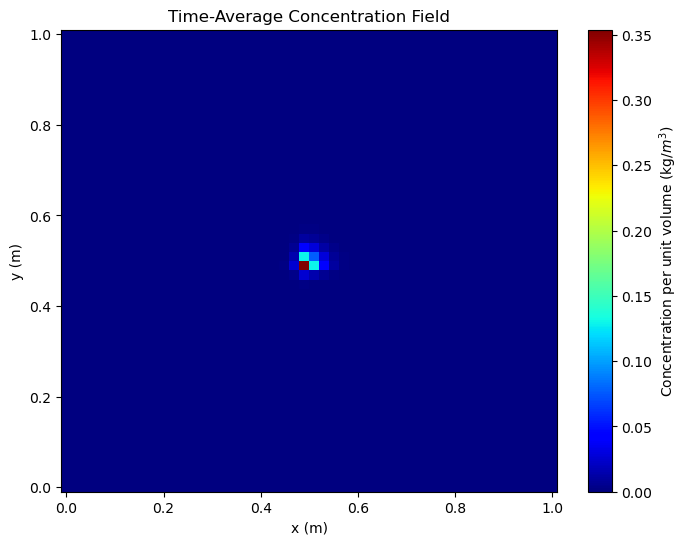

In [9]:
import matplotlib.pyplot as plt
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(8,6))
plt.pcolor(X, Y, np.mean(observed, axis=2), cmap='jet', shading='auto')
plt.colorbar(label="Concentration per unit volume (kg/$m^3$)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Time-Average Concentration Field")
# plt.savefig("plots/example_observed_01tend.png")
plt.show()

In [9]:
observed.shape

(50, 50, 100)

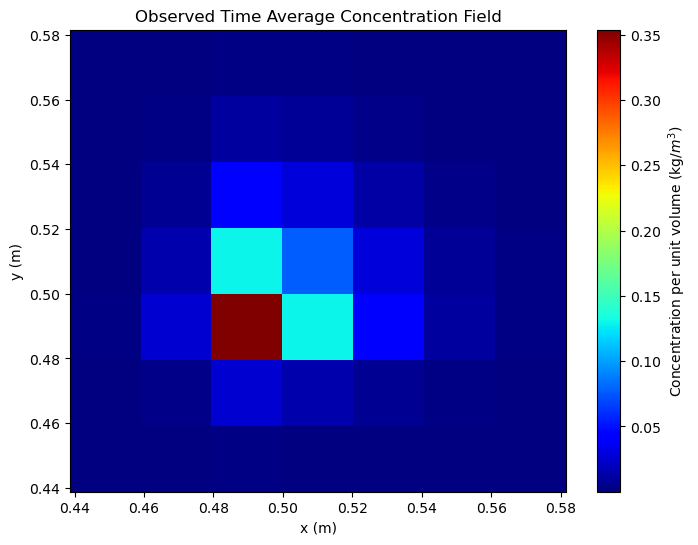

In [12]:
# Define the relevant index range manually
# x_min_idx, x_max_idx = 22, 27  # Find the grids that have some values for plume concentration
# y_min_idx, y_max_idx = 22, 27
x_min_idx, x_max_idx = 22, 29  # Find the grids that have some values for plume concentration
y_min_idx, y_max_idx = 22, 29

# Subset the arrays
filtered_observed = observed[y_min_idx:y_max_idx, x_min_idx:x_max_idx, :]
filtered_x = x[x_min_idx:x_max_idx]
filtered_y = y[y_min_idx:y_max_idx]

# Create the meshgrid
filtered_X, filtered_Y = np.meshgrid(filtered_x, filtered_y)

plt.figure(figsize=(8,6))
plt.pcolor(filtered_X, filtered_Y, np.mean(filtered_observed, axis=2), cmap='jet', shading='auto')
plt.colorbar(label="Concentration per unit volume (kg/$m^3$)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Observed Time Average Concentration Field")
# plt.savefig("plots/solution_no_advection01tend.png")
plt.show()

In [11]:
# filtered_observed.shape
# np.save("observed_data/no_noise_diffusion/no_noise_diffusion.npy", filtered_observed)

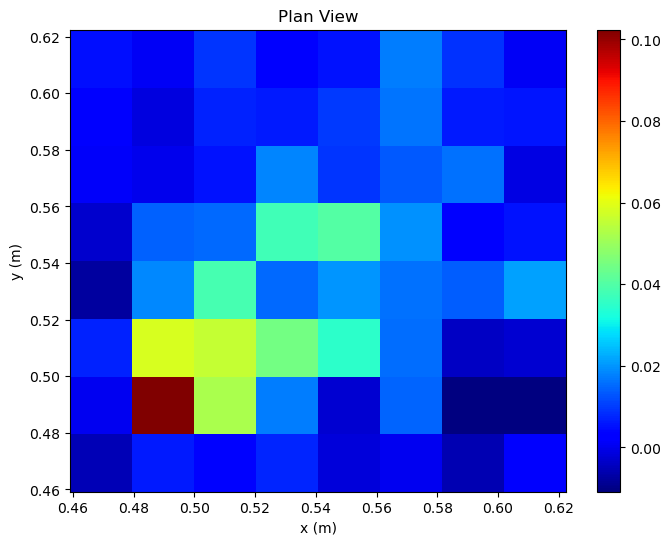

In [6]:
# Constant noise model - Adding gaussian noise to the observed
# Low Noise
# noise = np.random.normal(0, 0.025, (8, 8, 100))
# Medium Noise
# noise = np.random.normal(0, 0.05, (8, 8, 100))
# High Noise
noise = np.random.normal(0, 0.075, (8, 8, 100))
filtered_observed_noise = filtered_observed + noise

# Linear Noise
# linear_noise = np.zeros((8, 8, 100))
# temp_filtered_observed = np.transpose(filtered_observed, (2, 0, 1))
# for i in range(temp_filtered_observed.shape[0]):
#     temp_filtered_observed[i] = temp_filtered_observed[i] + np.random.normal(0, i*0.001, (8, 8))
    
# filtered_observed_noise = np.transpose(temp_filtered_observed, (1, 2, 0))

plt.figure(figsize=(8,6))
plt.pcolor(filtered_X, filtered_Y, np.mean(filtered_observed_noise, axis=2), cmap='jet', shading='auto')
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Plan View")
plt.show()

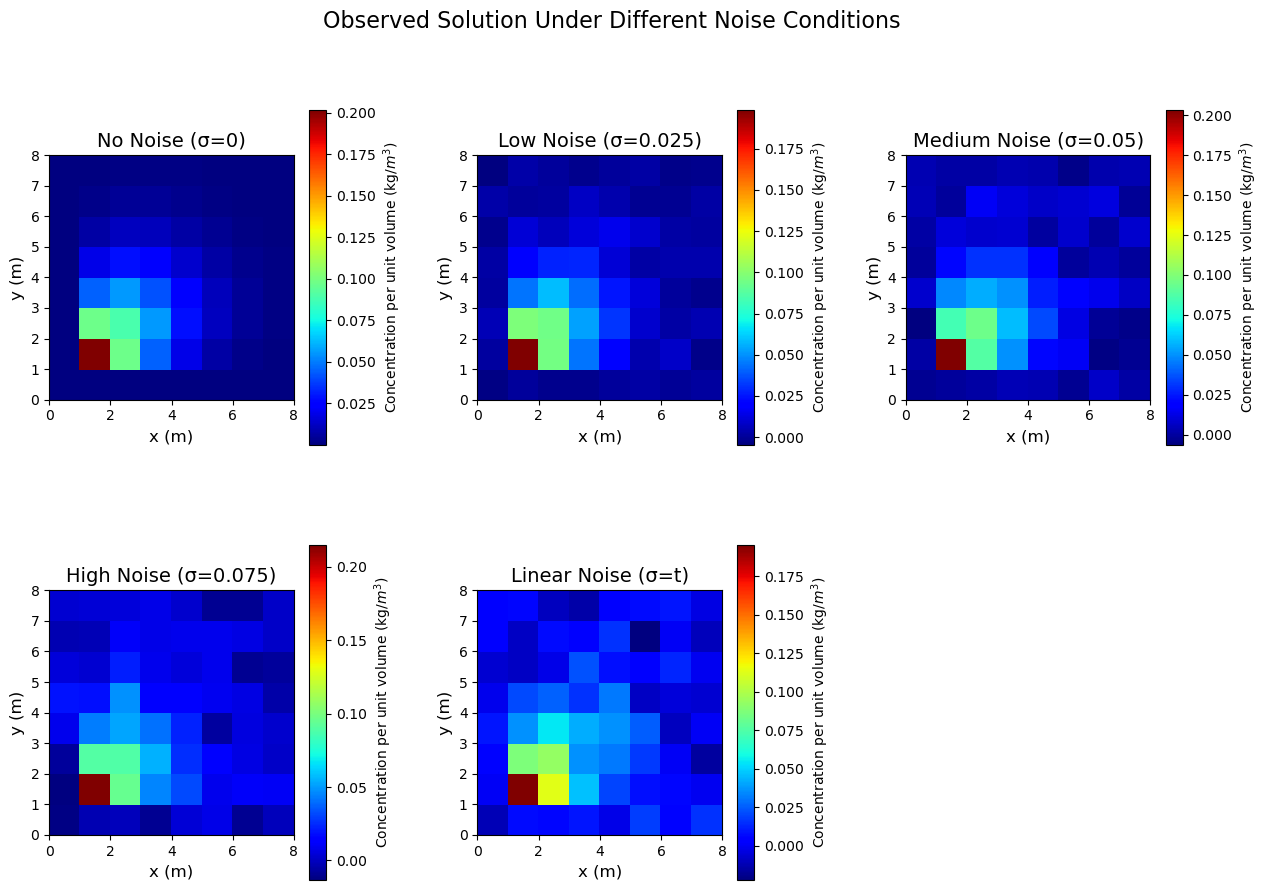

In [6]:
# Define noise levels
low_noise = np.random.normal(0, 0.025, (8, 8, 100))
medium_noise = np.random.normal(0, 0.05, (8, 8, 100))
high_noise = np.random.normal(0, 0.075, (8, 8, 100))

# Apply noise to observed data
filtered_observed_low = filtered_observed + low_noise
filtered_observed_medium = filtered_observed + medium_noise
filtered_observed_high = filtered_observed + high_noise

# Linear Noise
linear_noise = np.zeros((8, 8, 100))
temp_filtered_observed = np.transpose(filtered_observed.copy(), (2, 0, 1))
for i in range(temp_filtered_observed.shape[0]):
    temp_filtered_observed[i] = temp_filtered_observed[i] + np.random.normal(0, i * 0.002, (8, 8))
filtered_observed_linear = np.transpose(temp_filtered_observed, (1, 2, 0))

# Define noise levels dictionary
noise_levels = {
    "No Noise (σ=0)": filtered_observed,
    "Low Noise (σ=0.025)": filtered_observed_low,
    "Medium Noise (σ=0.05)": filtered_observed_medium,
    "High Noise (σ=0.075)": filtered_observed_high,
    "Linear Noise (σ=t)": filtered_observed_linear
}

# Create figure with subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes array
axes = axes.flatten()

# Plot each condition
for i, (title, data) in enumerate(noise_levels.items()):
    im = axes[i].pcolor(np.mean(data, axis=2), cmap='jet', shading='auto')
    fig.colorbar(im, ax=axes[i], label="Concentration per unit volume (kg/$m^3$)")
    axes[i].set_title(title, fontsize=14)
    axes[i].set_xlabel("x (m)", fontsize=12)
    axes[i].set_ylabel("y (m)", fontsize=12)
    axes[i].set_aspect('equal')  # Ensures aspect ratio is preserved

# Hide the unused subplot
axes[-1].axis('off')

fig.suptitle("Observed Solution Under Different Noise Conditions", fontsize=16)

# Adjust layout for better spacing
plt.subplots_adjust(hspace=0.3, wspace=0.4)

plt.savefig("plots/observed_sols.png")

# Show the plot
plt.show()

In [25]:
# np.save("no_noise.npy",filtered_observed)

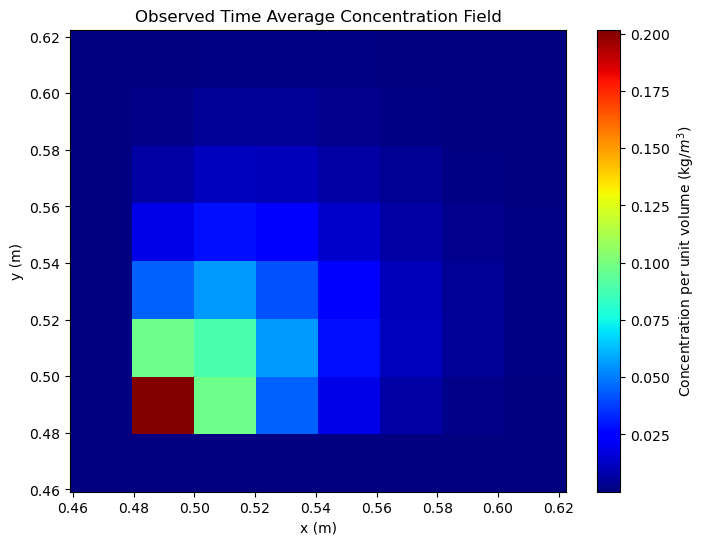

In [12]:
import numpy as np
import matplotlib.pyplot as plt
obs = np.load("observed_data/no_noise/no_noise.npy")
Nx, Ny= 50, 50  # Grid points
Lx, Ly = 1.0, 1.0  # Domain size in meters
x, y = np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)  # Centered at (0,0)

x_min_idx, x_max_idx = 23, 31  # Find the grids that have some values for plume concentration
y_min_idx, y_max_idx = 23, 31
filtered_x = x[x_min_idx:x_max_idx]
filtered_y = y[y_min_idx:y_max_idx]

filtered_X, filtered_Y = np.meshgrid(filtered_x, filtered_y)

plt.figure(figsize=(8,6))
plt.pcolor(filtered_X, filtered_Y, np.mean(obs, axis=2), cmap='jet', shading='auto')
plt.colorbar(label="Concentration per unit volume (kg/$m^3$)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Observed Time Average Concentration Field")
# plt.savefig("true_solution.png")
plt.show()